# Dynamical systems in Python

Quite frequently, engineering problems require simulation of dynamical system, i.e. systems governed by differential equations.

We will cover linear time invariant (LTI) systems as well as nonlinear systems.

The library of choice for LTI systems is control and especially the control.matlab library, which provides a very convenient interface.

In [1]:
from numpy import *             # Grab all of the NumPy functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
from control import step_response, forced_response, root_locus, phase_crossover_frequencies, margin, feedback, series

%matplotlib inline

### Introduction

The Python control library is quite similar to the equivalent Matlab library, which may be common to some of you. The basis forms the definition of a system, which may be defined in either

- Transfer function $G(s) = \frac{N(s)}{D(s)}$ or $G(z) = \frac{N(z)}{D(z)}$
- Statespace system $$\dot{x} = \mathbf{A}x + \mathbf{B}u$$ $$y = \mathbf{C}x+Du$$ for matrices $\mathbf{A}, \mathbf{B}, \mathbf{C}$, scalar $D$, state $x$, input $u$, output $y$ or its equivalent discrete time formulation.

We start be defining a system $$\ddot{y} + y = u$$ referring to an undamped pendulum which is given by the transfer function $G(s) = \frac{N(s)}{D(s)} = \frac{1}{s^2+1}$. The numerator and denominator polynomials are defined by their coefficients only, so $N(s)$ relates to the the array ```[1]```, while $D(s)$ relates to ```[1, 0, 1]```.


   1
-------
s^2 + 1



Text(0, 0.5, 'y')

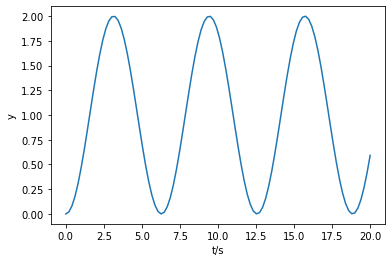

In [15]:
# Create system by calling tf
sys = tf([1], [1,0,1])
# Print the system
print(sys)
# Create time axis for simulation
Tin = linspace(0,20,100)
# Subject system to a step response to 1
T, yout = step_response(sys, Tin)
# Plot result
plot(T,yout)
xlabel('t/s')
ylabel('y')

As expected, the system exhibits a sustained oscillation due to the absence of damping.

## Exercise

- Add damping terms $b = 1,2,3$ to the system, yielding the transfer function $G(s) = \frac{N(s)}{D(s)} = \frac{1}{s^2+b+1}$. Plot the step responses.
- Define an array $u = \sin(\omega t_{in})$ for a linear time axis $t_{in}$. Use ```T, yout, x = forced_response(sys, Tin, u)```to simulate the system subjected to a $\sin$-Input for $\omega \in \{0.9, 1.0, 1.1\}$ and plot the results.

Using the ```label``` keyword in plot, you can recursively add a label to your plot and by using a loop, the plot can look like this:
![Resonancy plot](figures/Resonancy.png)

Text(0, 0.5, 'y')

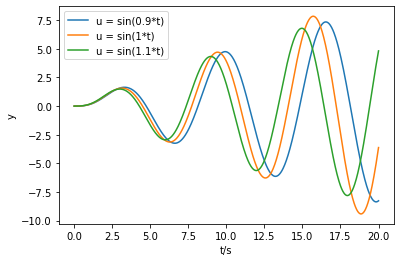

In [16]:
Tin = linspace(0,20,1000)
omegal = [0.9, 1, 1.1]
for omega in omegal:
    u = sin(omega*Tin)
    T, yout, x = forced_response(sys, Tin, u)
    # Plot result
    plot(T,yout, label = 'u = sin(' + str(omega) +'*t)')
    legend()
xlabel('t/s')
ylabel('y')

## More realistic model

In the sequel, we consider a mass-spring-damper-system (MSD-system) governed by the differential equation
\begin{equation}
\ddot{y}(t) + \frac{d}{m}\dot{y}(t) + \frac{c}{m}y(t) = \frac{1}{m}u(t)
\end{equation}
or, in state-space form,
\begin{equation}
\mathbf{A} = \begin{bmatrix}%{ccccc}
             0 & 1\\
            -a_{0} & -a_{1}   
            \end{bmatrix}
            = \begin{bmatrix}%{ccccc}
             0 & 1\\
            -\frac{c}{m} & -\frac{d}{m}   
            \end{bmatrix},
\end{equation}

\begin{equation}
\mathbf{B} = \begin{bmatrix} 0 \\ 1\end{bmatrix} 
\end{equation}

\begin{equation}
\mathbf{C} = \begin{bmatrix} \frac{1}{m} & 0\end{bmatrix}
\end{equation}

\begin{equation*}
D = 0
\end{equation*}

The parameters are:

- Mass $m$
- Spring constant $c$
- Damper constant $b$

Such a system can be defined parametrically, so we can quickly re-run the simulation for different systems.

In [3]:
# Parameter definition
m = 10
c = 5
d = 1
# State space arrays
A = array([[0,1],[-c/m, -d/m]])
B = array([[0],[1]])
C = array([1/m, 0])
sys = StateSpace(A, B, C, 0)

## System behaviour

Investigate system behaviour by help of a step response.

Text(0, 0.5, 'y')

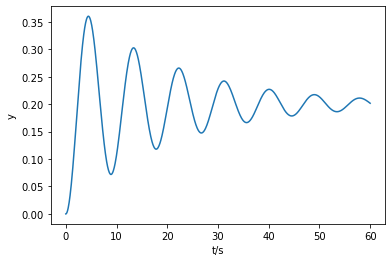

In [4]:
Tin = linspace(0,60, 1000)
T, yout = step_response(sys, Tin)
plot(T,yout)
xlabel('t/s')
ylabel('y')

### System analysis

For a linear system, we can investigate the system behaviour well by inspecting

- DC gain, i.e. what is the system amplification after settling of any overshoots
- Poles and Zeros, i.e. is the system stable (all poles on the left hand side of the complex plane) and does it oscillate (complex conjugate pairs of poles)
- Helpful combination (termed sisotool) to determine behaviour and stability consisting of

    - Bode plot
    - Root-locus plot (mostly for closed loop systems)
    - Step responce
    

DC gain: 0.2


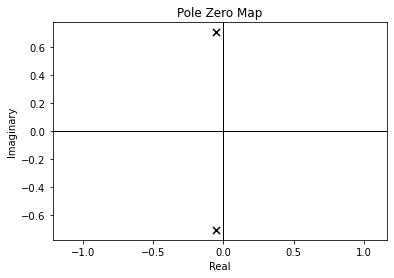

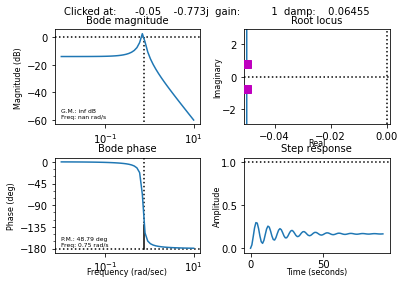

In [5]:
# Print out DC gain
print('DC gain: ' +str(dcgain(sys)))
# Open a new figure
figure()
# Plot pole zero map
pzmap(sys)
# Open a new figure
figure()
# Plot combination figure
sisotool(sys)

### Exercise

Define two alternative MSD-systems with

1. Both poles on the imaginary axis (marginally stable) 
2. Both poles on the real axis (left half obviously)

and plot the pole-zero maps of each.

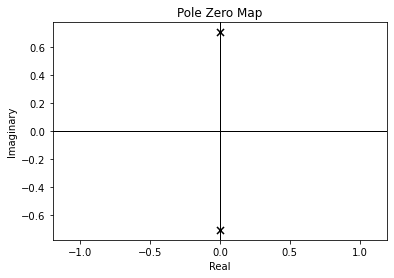

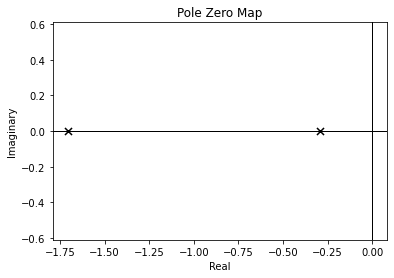

In [20]:
###########################
# System 1
# Parameter definition
m = 10
c = 5
d = 0
# State space arrays
A = array([[0,1],[-c/m, -d/m]])
B = array([[0],[1]])
C = array([1/m, 0])
sys = StateSpace(A, B, C, 0)
pzmap(sys)
#############################
# new figure
figure()
###########################
# System 2
# Parameter definition
m = 10
c = 5
d = 20
# State space arrays
A = array([[0,1],[-c/m, -d/m]])
B = array([[0],[1]])
C = array([1/m, 0])
sys = StateSpace(A, B, C, 0)
ret = pzmap(sys)

### Desired closed-loop behaviour

With a pair of poles at $\lambda_{1/2} = a\pm b j$ a quick settling time can be achieved.

In [6]:
a = -5
b = 0.1
ssg = (a**2+b**2)/c
Ad = array([[0,1],[-1*(a**2+b**2), -1*(-2*a)]])
Bd = array([[0],[1]])
Cd = array([ssg, 0])
sysd = StateSpace(Ad, Bd, Cd, 0)

Text(0, 0.5, 'y')

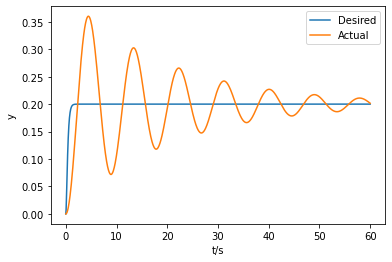

In [7]:
youtd, T = step(sysd, Tin)
plot(T,youtd, label = 'Desired')
plot(T, yout, label = 'Actual')
legend()
xlabel('t/s')
ylabel('y')
#savefig('plots/DesiredvsActual.png', dpi = 600)

## State feedback

Here we introduce full state feedback according to
\begin{equation*}
\mathbf{F} = \begin{bmatrix} \left(a^2+b^2 - \frac{c}{m}\right) & \left(-2a - \frac{b}{m}\right)\end{bmatrix}
\end{equation*}
and simulate a step response.

Text(0, 0.5, 'y')

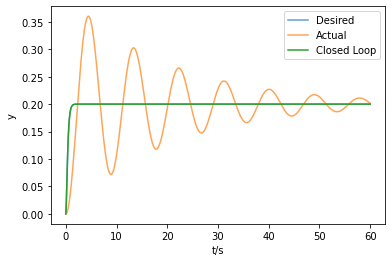

In [8]:
F = array([a**2+b**2-c/m, -2*a-d/m])
Acl = A-B*F
Bcl = array([[0],[1]])
Ccl = array([ssg, 0])
syscl = StateSpace(Acl, Bcl, Ccl,0)
youtcl, T = step(syscl, Tin)
plot(T,youtd, label = 'Desired', alpha = 0.7)
plot(T, yout, label = 'Actual', alpha = 0.7)
plot(T, youtcl, label = 'Closed Loop')
legend()
xlabel('t/s')
ylabel('y')
#savefig('plots/DesiredvsActualvsClosedLoop.png', dpi = 600)

## Exercise

State feedback assumes perfect knowledge of the plant parameters. Manipulate the parameters (A, B, C) of the system unknown to the controller, check and document the results.

Text(0, 0.5, 'y')

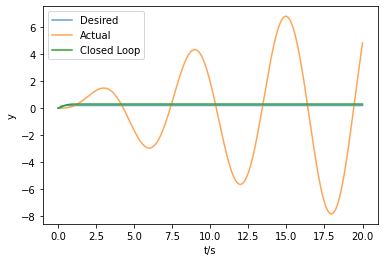

In [26]:
F = array([a**2+b**2-c/m, -2*a-d/m])
######################################
# Random disturbance added:
Acl = (A+2*random.random((2,2)))-B*F
Bcl = array([[0],[1]])
Ccl = array([ssg, 0])
syscl = StateSpace(Acl, Bcl, Ccl,0)
youtcl, T = step(syscl, Tin)
plot(T,youtd, label = 'Desired', alpha = 0.7)
plot(T, yout, label = 'Actual', alpha = 0.7)
plot(T, youtcl, label = 'Closed Loop')
legend()
xlabel('t/s')
ylabel('y')
#savefig('plots/DesiredvsActualvsClosedLoop.png', dpi = 600)

## Interconnections and Feedback

It is possible to assemble dynamical systems from blocks of subsystems by interconnection in the direction of signal flow as well as feedback.

### Series interconnection

We will initially couple two first order systems:

- $G_1(s) = \frac{1}{s+1}$
- $G_2(s) = \frac{1}{s+2}$

![System interconnection](figures/Interconnection.png)

The resulting System, $G(s) = G_1(s) G_2(s)$, is then subjected to a step response and compared to the individual subsystems. In the resulting plot, we clearly see the second order nature of the interconnected response.

Text(0, 0.5, 'y')

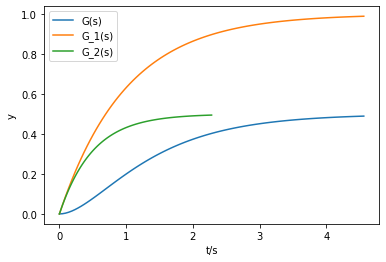

In [9]:
# Create both system
sys1 = tf([1],[1, 1])
sys2 = tf([1],[1, 2])

# Series interconnection
sys = series(sys1, sys2)
# Step response simulation
T, yout = step_response(sys)
T1, yout1 = step_response(sys1)
T2, yout2 = step_response(sys2)
# Plotting
plot(T, yout, label = 'G(s)')
plot(T1, yout1, label = 'G_1(s)')
plot(T2, yout2, label = 'G_2(s)')
legend()
xlabel('t/s')
ylabel('y')

### Feedback interconnection

For the feedback interconnection, we will add a feedback compensator to the heavily overshooting plant
$$G_1(s) = \frac{20}{s^2+2s+20}$$
according to the transfer function
$$G_{comp} = K s.$$

G(s) = 
      20
--------------
s^2 + 9 s + 20

Poles of closed loop system: [-5. -4.]


Text(0, 0.5, 'y')

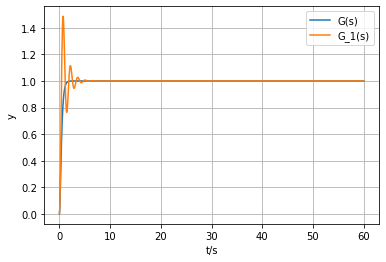

In [10]:
# Generate both systems
sys1 = tf([20],[1, 2, 20])
# Parametric gain
K = .35
comp = tf([K, 0], [1])

##########################
# Feedback interconnection
sys = feedback(sys1, comp)

###########################
# Print the overall system
print('G(s) = ' + str(sys))
# Print poles of closed loop system
print('Poles of closed loop system: ' + str(pole(sys)))

###########################
# Plotting
T, yout = step_response(sys,Tin)
T1, yout1 = step_response(sys1, Tin)
plot(T, yout, label = 'G(s)')
plot(T1, yout1, label = 'G_1(s)')
legend()
grid()
xlabel('t/s')
ylabel('y')

## DC Motor example

A linear model of a DC motor consists of a mechanical part and the electrical part.

The mechanical part is a rotating mass, so exhibiting inertia $J$ as well as some damping $B$.

The electrical subsystem consists of the armature resistance $R_a$, the armature inductance $L_a$. A loop according to Kirchhoff's Law also reveals a back-EMF voltage $U_b$.

![](figures/DCMotor.png)

This back-EMF is linked to the rotational velocity $\omega$ according to $$U_b = K_b \omega$$ while the generated torque is depending on the current in the armature $I_a$ according to
$$T = K_T I_a.$$

The input voltage $U_a$ drives the armature current according to
$$U_a = L_a \frac{dI_a}{dt} + R_a I_a + U_b,$$ after a Laplace Transform yielding the transfer function
$$\frac{I_a}{U_a - U_b} = \frac{1}{L_a s+R_a}$$
for the electrical subsystem. Note the transfer of $$U_a - U_b \rightarrow I_a,$$ indicating a feedback from the output velocity.

The mechanical subsystem is an inertial, damped system, governed by the transfer function
$$\frac{\omega}{T_m} = \frac{1}{Js+B}$$.

The back-EMF is proportional to $\omega$ according to $$Ub = K_b \omega.$$

The overall block diagram is shown below:

![](figures/DCMotorBlock.png)

## Exercise

Implement a DC motor model and simulate the step response as well as a forced response to a sinewave.

1. Define the system parameters:
    - $R_a = 5$
    - $L_a = 0.1$
    - $K_T = 10$
    - $J = 1$
    - $B = 0.001$
    - $K_b = 1$
1. Model the subsystems:
    1. Electrical subsystem
    1. Torque constant $K_T$ as a transfer function ```tf([KT],[1])```
    1. Mechanical subsystem
    1. Back-EMF constant as $K_T$
1. Interconnect according to the block diagram above
    1. Start with forward path
    1. Add feedback
1. Simulate and plot
    1. subject the system to a unit step
    1. Subject the system to a 12V-sine voltage with $2\pi$ frequency. Use the code snippets
~~~.py
figure(figsize=(10,6))
subplot(3,1,(1,2))
~~~
and 
~~~.py
figure(figsize=(10,6))
subplot(3,1,3)
~~~
to replicate this figure:
![DCMotor Results](figures/DCMotorSim.png)


         10
---------------------
0.1 s^2 + 5 s + 10.01



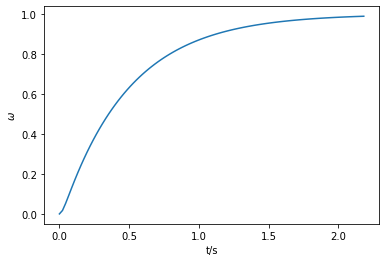

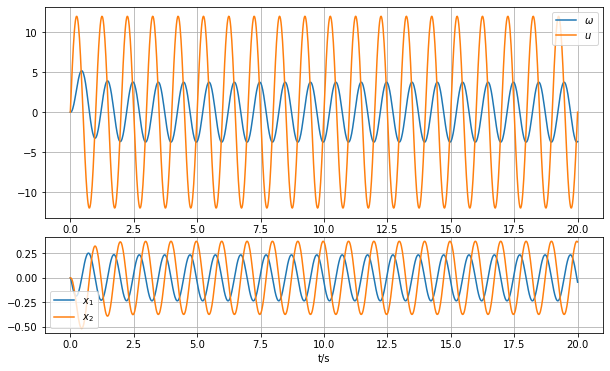

In [27]:
# Parameters
Ra = 5
La = 0.1
KT = 10
J = 1
B = 0.001
Kb = 1
# Subsystem definition
syse = tf([1],[La,Ra])
sysm = tf([1],[J,B])
sysKT = tf([KT],[1])
sysKb = tf([Kb],[1])
# Forward path
sysfw = series(syse, sysKT, sysm)
# Feedback
sys = feedback(sysfw, sysKb)
# Print overall system
print(sys)

# Step response
T, yout = step_response(sys)
plot(T, yout)
xlabel('t/s')
ylabel('$\omega$')

# Forced response
T = linspace(0,20,1000)
u = 12*sin(2*pi*T)
Tout, yout, x = forced_response(sys, T, u, [0, 0])
figure(figsize=(10,6))
subplot(3,1,(1,2))
plot(Tout, yout, label = '$\omega$')
plot(T, u, label = '$u$')
grid()
legend()
subplot(3,1,3)
plot(Tout, x[0,:], label = '$x_1$')
plot(Tout, x[1,:], label = '$x_2$')
grid()
legend()
xlabel('t/s')
savefig('figures/DCMotorSim.png', dpi=300)

## Nonlinear systems

As a nonlinear system example, we consider the mathematical pendulum as depicted below:

![Pendulum](figures/Pendulum.png)

This system is governed by the differential equation $$\ddot{\varphi} + \frac{g}{l}\sin(\varphi) = 0$$

While linear systems are somewhat easier to handle, we need to explicitly define the function to transfer the states. Also we need to import and utilise an ODE solver, which is contained in the scipy.integrate library.

In [11]:
from scipy import integrate

Next, we need to define the nonlinear differential equation in terms of a first order differential equation, i.e. mapping a state vector $x$ to its derivative $\dot{x} = f(x)$. Since time dependence can be implemented, it needs to accept both time and state.

The state space representation of the above ODE is

$$\dot{x} = \begin{pmatrix} \dot{x}_1 \\ \dot{x}_2 \end{pmatrix}  = \begin{pmatrix} x_2 \\ \frac{-g}{l}\sin\left(x_2\right) \end{pmatrix}.$$

This is implemented below:

In [12]:
## Nonlinear state space function
def f(x,t=0):
    # Parameters
    g = 9.81
    l = 10
    # Return state differential
    return [x[1], -g/l*np.sin(x[0])]

### Phase portrait

A good way to think about nonlinear systems is to consider their phase portrait, i.e. a directional field to observer their evolution from an arbitrary starting point.

For this purpose, we use ```meshgrid``` to generate linear increasing matrices over a given value range.

Text(0, 0.5, '$x_2$')

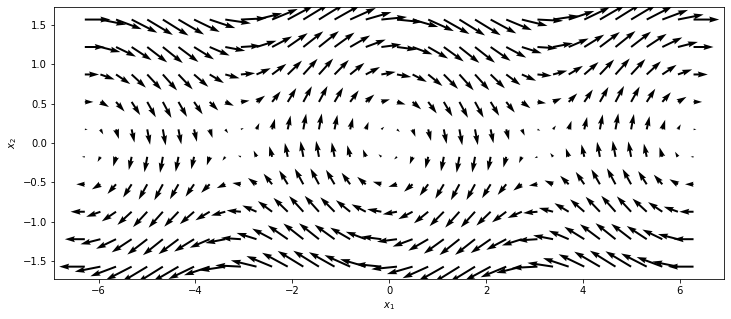

In [13]:
# Create figure and axis objects
fig = figure(num=1, figsize = (12,5))
ax=fig.add_subplot(111)
# Create two matrices
X1,X2 = np.meshgrid(np.linspace(-2*np.pi,2*np.pi,40),np.linspace(-np.pi/2,np.pi/2,10))
# Calculate differentials
DX1, DX2 = f([X1,X2])
# Plot as a vector field
ax.quiver(X1,X2,DX1,DX2)
# Label axes
xlabel("$x_1$")
ylabel("$x_2$")

In the phase portrait, we clearly see the points of stability for $(k\pi,0)^T,\, k = 0, 1,\ldots$, with even $k$ indicating the lower point of stability.

It is time to plot some trajectories. To achieve this, we solve the ODE using ```integrate.odeint``` with options:

- f, the name of the function
- x0, the initial state
- t, a time vector defined beforehand

The return value is an array of the state evolution, which can be plotted after transposing. In order to evaluate the different initial conditions, we loop through these.

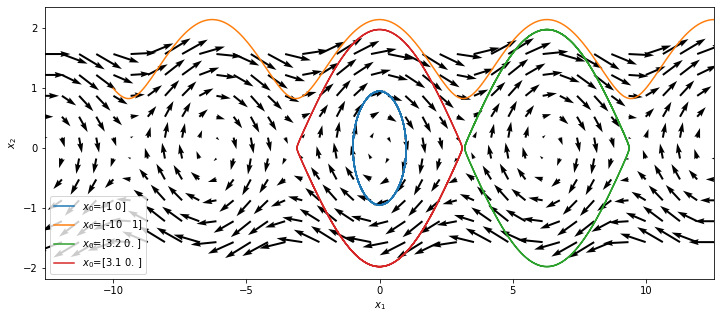

In [14]:
fig = figure(num=1, figsize = (12,5))
ax=fig.add_subplot(111)
# Time axis for solution (with fine resolution)
t = np.linspace(0,50,1000)
# Array of initial conditions
X0 = [np.array([1,0]), np.array([-10,1]), np.array([3.2,0]), np.array([3.1,0])]

# Plot phase portrait as above
X1,X2 = np.meshgrid(np.linspace(-4*np.pi,4*np.pi,40),np.linspace(-np.pi/2,np.pi/2,10))
DX1, DX2 = f([X1,X2])
ax.quiver(X1,X2,DX1,DX2)
for x0 in X0:
    # Call ODE solver
    P = integrate.odeint(f, x0, t).T
    # Plot the resulting curve and add label
    ax.plot(P[0],P[1], label = '$x_0$='+str(x0))
# Limit x-axis - Some solutions evolve too far.
xlim([-4*np.pi, 4*np.pi])
xlabel("$x_1$")
ylabel("$x_2$")
# Show initial condition labels
legend()

## Exercise

Extend the nonlinear system example above to include friction, the updated state space formulation shall be

$$\dot{x} = \begin{pmatrix} \dot{x}_1 \\ \dot{x}_2 \end{pmatrix}  = \begin{pmatrix} x_2  \\ \frac{-g}{l}\sin\left(x_2\right) - \mu x_1 \end{pmatrix}.$$

Select $\mu = 0.1$ as a friction coefficient and plot the according trajectories.

In [28]:
## Nonlinear state space function including damping
def f2(x,t=0):
    # Parameters
    mu = 0.1
    g = 9.81
    l = 10
    # Return state differential
    return [x[1], -g/l*np.sin(x[0]) - mu*x[1]]

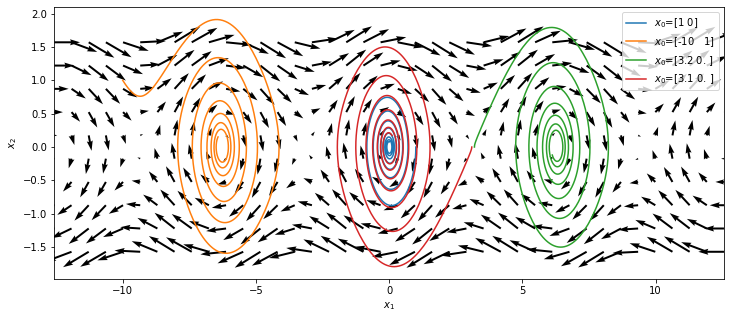

In [29]:
fig = figure(num=1, figsize = (12,5))
ax=fig.add_subplot(111)
# Time axis for solution (with fine resolution)
t = np.linspace(0,50,1000)
# Array of initial conditions
X0 = [np.array([1,0]), np.array([-10,1]), np.array([3.2,0]), np.array([3.1,0])]

# Plot phase portrait as above
X1,X2 = np.meshgrid(np.linspace(-4*np.pi,4*np.pi,40),np.linspace(-np.pi/2,np.pi/2,10))
DX1, DX2 = f([X1,X2])
ax.quiver(X1,X2,DX1,DX2)
for x0 in X0:
    # Call ODE solver
    P = integrate.odeint(f2, x0, t).T
    # Plot the resulting curve and add label
    ax.plot(P[0],P[1], label = '$x_0$='+str(x0))
# Limit x-axis - Some solutions evolve too far.
xlim([-4*np.pi, 4*np.pi])
xlabel("$x_1$")
ylabel("$x_2$")
# Show initial condition labels
legend()